In [ ]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scripts.utils import load_from_pickle
from scipy.stats import chisquare
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Function definitions

In [6]:

def calculate_matrix_orders(arr):
    # get the indices that would sort each row of the array
    sort_indices = np.argsort(-arr, axis=1)

    # create an array to mark the sorted order
    sorted_order = np.empty_like(sort_indices)
    rows, cols = np.indices(arr.shape)
    sorted_order[rows, sort_indices] = cols

    # replace each entry in the original array with its index in the sorted order
    result = sorted_order.astype(int)

    return result



def get_genes_by_factor(res):
    gene_w = res['gene_weights'].T
    genes = list(res['genes'].index)

    # create ranking matrices from the NMF weights
    mat_1 = calculate_matrix_orders(gene_w.T).T
    mat_2 = calculate_matrix_orders(gene_w)

    # Iterate through the factors (columns)
    genes_by_factors = {}
    for factor in range(gene_w.shape[1]):
        valid_genes = list()
        # Iterate through the genes, starting from the highest weighted gene of this factor
        for i in np.argsort(mat_1[:,factor]): 
            if mat_2[i,factor] ==0: # Is this the factor the gene effects the most?
                
                # If yes, add it to the list of genes
                valid_genes.append(genes[i])
            else:
                # if not, stop adding genes into the list, move on to the next factor
                break 
        # Append the list of valid genes into a dictionary under the appropriate key
        genes_by_factors['factor'+str(factor)] = valid_genes
    
    return genes_by_factors


def calculate_phenotype_distributions(df,factor):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = bground_proportions.index

    # The number of cells scoring highest on this factor
    subset = df[df['max_factor'] == factor]
    # Expected proportions based on the celltype proportions
    expected = bground_proportions*len(subset)

    observed = subset['phenotype'].value_counts()[order]

    contig_table = pd.DataFrame({'expected':expected.astype(int),
    'observed':observed,
    'diff':observed-expected.astype(int)})

    pval = chisquare(observed,expected).pvalue

    print(contig_table)
    print('chi2 test p-value: ' + str(pval))


def score_modules(ctype, n_comps):
    dat = sc.read_h5ad(ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    res = load_from_pickle('sc_modules/data/'+ctype+'_'+str(n_comps)+'_modules_nsnmf_results.pickle')
    genes_dict = get_genes_by_factor(res)
    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k)

    # Find the column with the highest score and add a new column for the corresponding factor.
    score_cols = list(genes_dict.keys())
    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_factor'] = max_col

    obs_with_scores = dat.obs.copy()
    del dat

    return(obs_with_scores,genes_dict)

def summarize_factor(df, factor, g_dict):
    n_present_samples = len(np.unique(df[df['max_factor']==factor]['sample']))
    n_dsets = len(np.unique(df[df['max_factor']==factor]['dataset']))
    n_total_samples = len(df['sample'].cat.categories)
    n_total = len(df[df['max_factor']==factor])
    print(factor + ': '+ str(n_total) +' top-scoring cells present in '+str(n_present_samples)+' out of '
          +str(n_total_samples)+' samples and ' + str(n_dsets) + ' datasets')
    print('')
    calculate_phenotype_distributions(df,factor)
    print(' ')
    print('Top 5 contributing genes:')
    for g in g_dict[factor][:5]:
        print(g)
    print(' ')
    print('************************')
    print(' ')
    
def plot_score_violins(scores_df):
    # Take all columns with factor in their name
    factor_columns = [col for col in scores_df.columns if 'factor' in col]
    # Drop the size_factors column
    factor_columns = [f for f in factor_columns if f != 'size_factors']

    if len(factor_columns) > 0:
        violin_df = scores_df[factor_columns]

        rows = len(factor_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))

        for i in range(len(factor_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x='max_factor', y=factor_columns[i], ax=axs[row][col])
            axs[row][col].tick_params(axis='x', rotation=30)

            # Get the 1st quantile of highest scoring factor
            val_80 = violin_df.loc[violin_df['max_factor'] == factor_columns[i],factor_columns[i]].quantile(q=0.25)

            # Add horizontal line
            axs[row][col].axhline(y=val_80, color='black', linestyle='--')

        
        plt.show()
    else:
        print("No columns found with 'factor' in their names.")


def save_dict_to_excel(df_with_factors,ctype,n_factors):
    # Saves the factors to a dataframe and onto an excel sheet
    max_length = max(len(lst) for lst in df_with_factors.values())
    for key in df_with_factors:
        df_with_factors[key].extend([np.nan]*(max_length - len(df_with_factors[key])))

    df_with_factors = pd.DataFrame.from_dict(df_with_factors)
    df_with_factors.to_excel(ctype+'_'+str(n_factors)+'_factors_'+datetime.today().strftime('%Y%m%d')+'.xlsx')



## Loading the NMF gene lists and scoring them

In [ ]:
# The number of components used is determined as the highest 
# n that yileds at least 20 unique genes in each component.
# Very similar to the one used in Barkley et al. Nat Genetics 2022

nmf_components_by_ctype = {
    'T_cell': 5, 
    'Myeloid': 16,
    'Fibroblast_muscle': 13,
    'Epithelial': 9, 
    'Endothelial': 11,
    }

# Create a dataframe for the final annotations 
final_annotations = pd.DataFrame()

### Epithelial

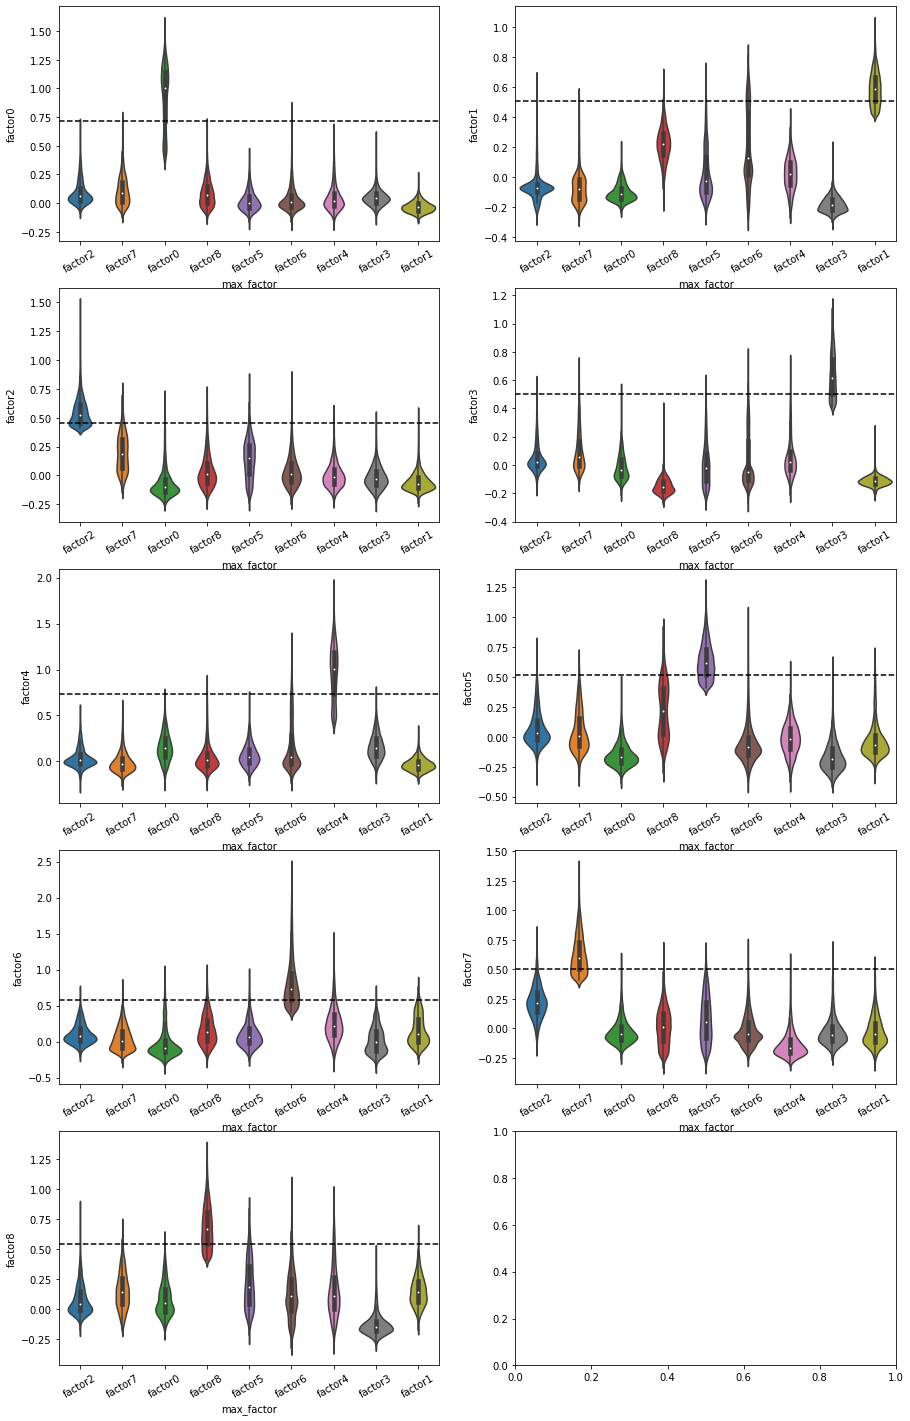

In [7]:
scores, genes_dict = score_modules('Epithelial',nmf_components_by_ctype['Epithelial'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Epithelial',nmf_components_by_ctype['Epithelial'])

In [8]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 2731 top-scoring cells present in 28 out of 96 samples and 5 datasets

        expected  observed  diff
PCa         1743       398 -1345
normal       582         3  -579
CRPC         404      2330  1926
chi2 test p-value: 0.0
 
Top 5 contributing genes:
OCIAD2
PGM2L1
SOX4
TUBA1A
IGFBP2
 
************************
 
factor1: 9633 top-scoring cells present in 59 out of 96 samples and 6 datasets

        expected  observed  diff
PCa         6149      5016 -1133
normal      2055      4613  2558
CRPC        1427         4 -1423
chi2 test p-value: 0.0
 
Top 5 contributing genes:
KLK3
STEAP2
AZGP1
SLC45A3
RDH11
 
************************
 
factor2: 3428 top-scoring cells present in 83 out of 96 samples and 7 datasets

        expected  observed  diff
PCa         2188      2149   -39
normal       731       531  -200
CRPC         508       748   240
chi2 test p-value: 2.111235251684211e-37
 
Top 5 contributing genes:
NBEAL1
CXCR4
ZFP36L1
CCL4
SRGN
 
************************
 
factor3: 8

In [9]:
# Rename the columns accordingly
replacements = {'factor0':'cycling epithelium','factor1':'healthy luminal epithelium',
                    'factor2':'interferon signalling epithelium','factor3':'EMT epithelium',
                    'factor4':'TMC5 cancer luminal epithelium','factor5':'club epithelium',
                    'factor6':'metal response epithelium','factor7':'basal epithelium',
                    'factor8':'cancer luminal epithelium '
                    }


for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

### T cell

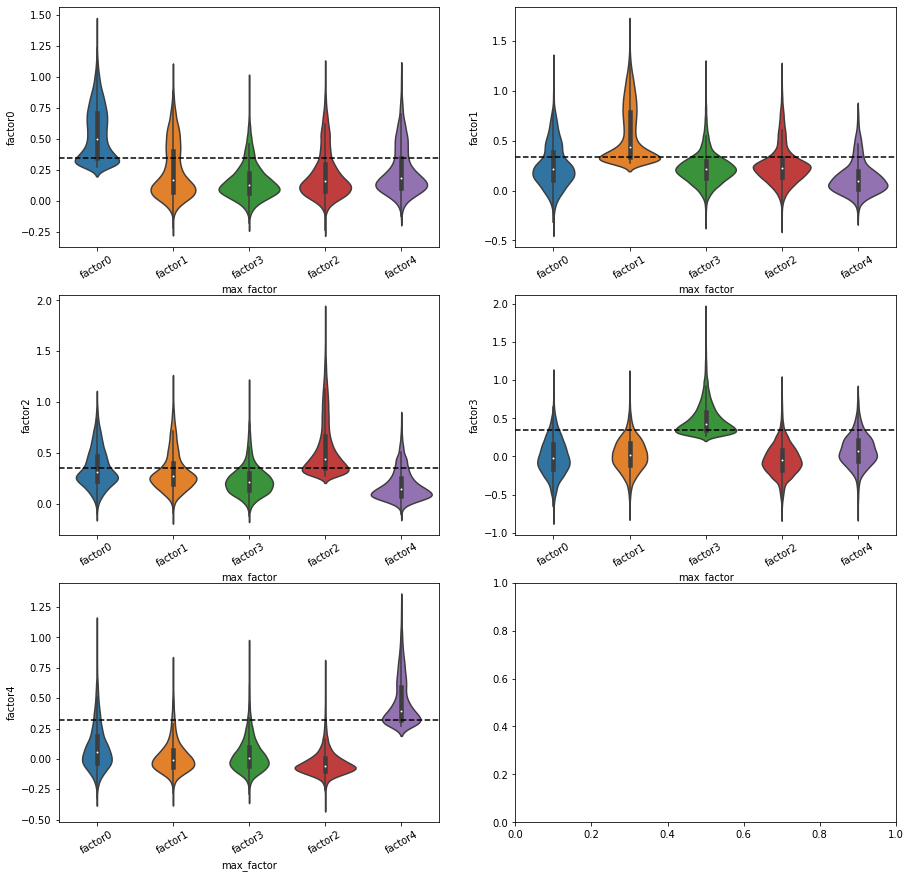

In [10]:
scores, genes_dict = score_modules('T_cell',nmf_components_by_ctype['T_cell'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'T_cell',nmf_components_by_ctype['T_cell'])

In [11]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 6875 top-scoring cells present in 81 out of 96 samples and 7 datasets

        expected  observed  diff
PCa         3833      4058   225
normal      2821      1833  -988
CRPC         219       984   765
chi2 test p-value: 0.0
 
Top 5 contributing genes:
GZMK
CHCHD10
HLA-B
SOCS1
YBX1
 
************************
 
factor1: 20530 top-scoring cells present in 84 out of 96 samples and 7 datasets

        expected  observed  diff
PCa        11448     11998   550
normal      8426      8207  -219
CRPC         655       325  -330
chi2 test p-value: 6.068899285876974e-44
 
Top 5 contributing genes:
ZFP36
MYADM
TUBA4A
ZFP36L2
RGCC
 
************************
 
factor2: 42640 top-scoring cells present in 82 out of 96 samples and 7 datasets

        expected  observed  diff
PCa        23777     23879   102
normal     17500     17859   359
CRPC        1362       902  -460
chi2 test p-value: 3.567977784430407e-36
 
Top 5 contributing genes:
CTSW
NKG7
KLRD1
HOPX
GZMH
 
************************


In [12]:
# Rename the columns accordingly
replacements = {'factor0':'activated T cells','factor1':'effector T cells',
                    'factor2':'natural killer cells','factor3':'resident memory T cells',
                    'factor4':'helper T cells'
                    }


for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

### Myeloid

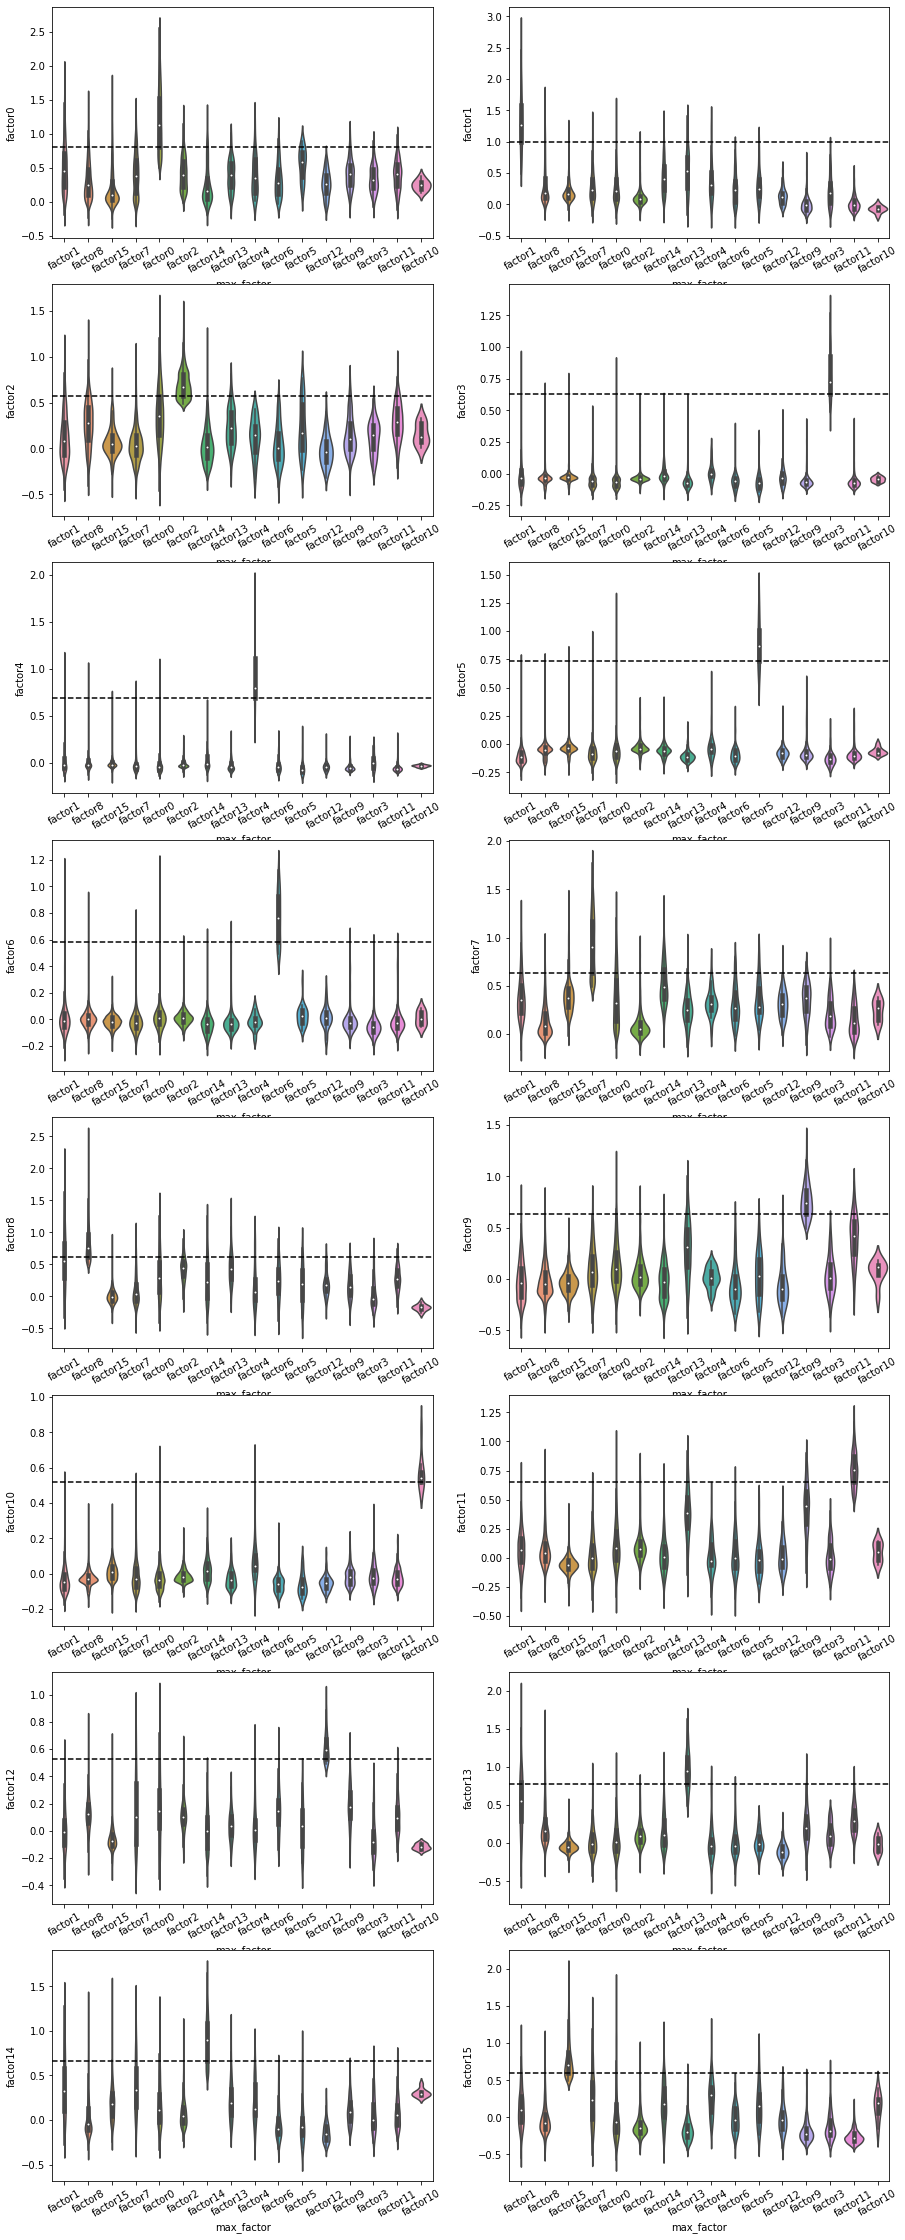

In [13]:
scores, genes_dict = score_modules('Myeloid',nmf_components_by_ctype['Myeloid'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Myeloid',nmf_components_by_ctype['Myeloid'])

In [14]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 5350 top-scoring cells present in 79 out of 98 samples and 7 datasets

        expected  observed  diff
PCa         3471      3982   511
normal      1416      1159  -257
CRPC         461       209  -252
chi2 test p-value: 3.365507811828098e-57
 
Top 5 contributing genes:
HSPA1A
DNAJB1
HSP90AA1
HSPE1
HSPA1B
 
************************
 
factor1: 1867 top-scoring cells present in 77 out of 98 samples and 7 datasets

        expected  observed  diff
PCa         1211      1115   -96
normal       494       238  -256
CRPC         161       514   353
chi2 test p-value: 6.474608656418687e-199
 
Top 5 contributing genes:
FTL
APOC1
APOE
MT2A
NUPR1
 
************************
 
factor2: 1279 top-scoring cells present in 70 out of 98 samples and 7 datasets

        expected  observed  diff
PCa          830       939   109
normal       338       338     0
CRPC         110         2  -108
chi2 test p-value: 5.9612887483456546e-27
 
Top 5 contributing genes:
FOS
GADD45B
IER2
CD14
SGK1
 
******

In [15]:
# Rename the columns accordingly
replacements = {'factor0':'stress response myeloids','factor1':'FTL macrophages',
                    'factor2':'stress response hypoxic myeloids','factor3':'luminal-like monocytes',
                    'factor4':'drop','factor5':'drop',
                    'factor6':'cycling myeloids','factor7':'suppressory monocytes',
                    'factor8':'C1Qx macrophages','factor9':'cytokine signalling myeloids',
                    'factor10':'drop','factor11':'metal response myeloids',
                    'factor12':'HLA-DQx myeloids','factor13':'viral reaction macrophages',
                    'factor14':'inflammation response myeloids','factor15':'monocytes',
                    }

for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

### Fibroblasts

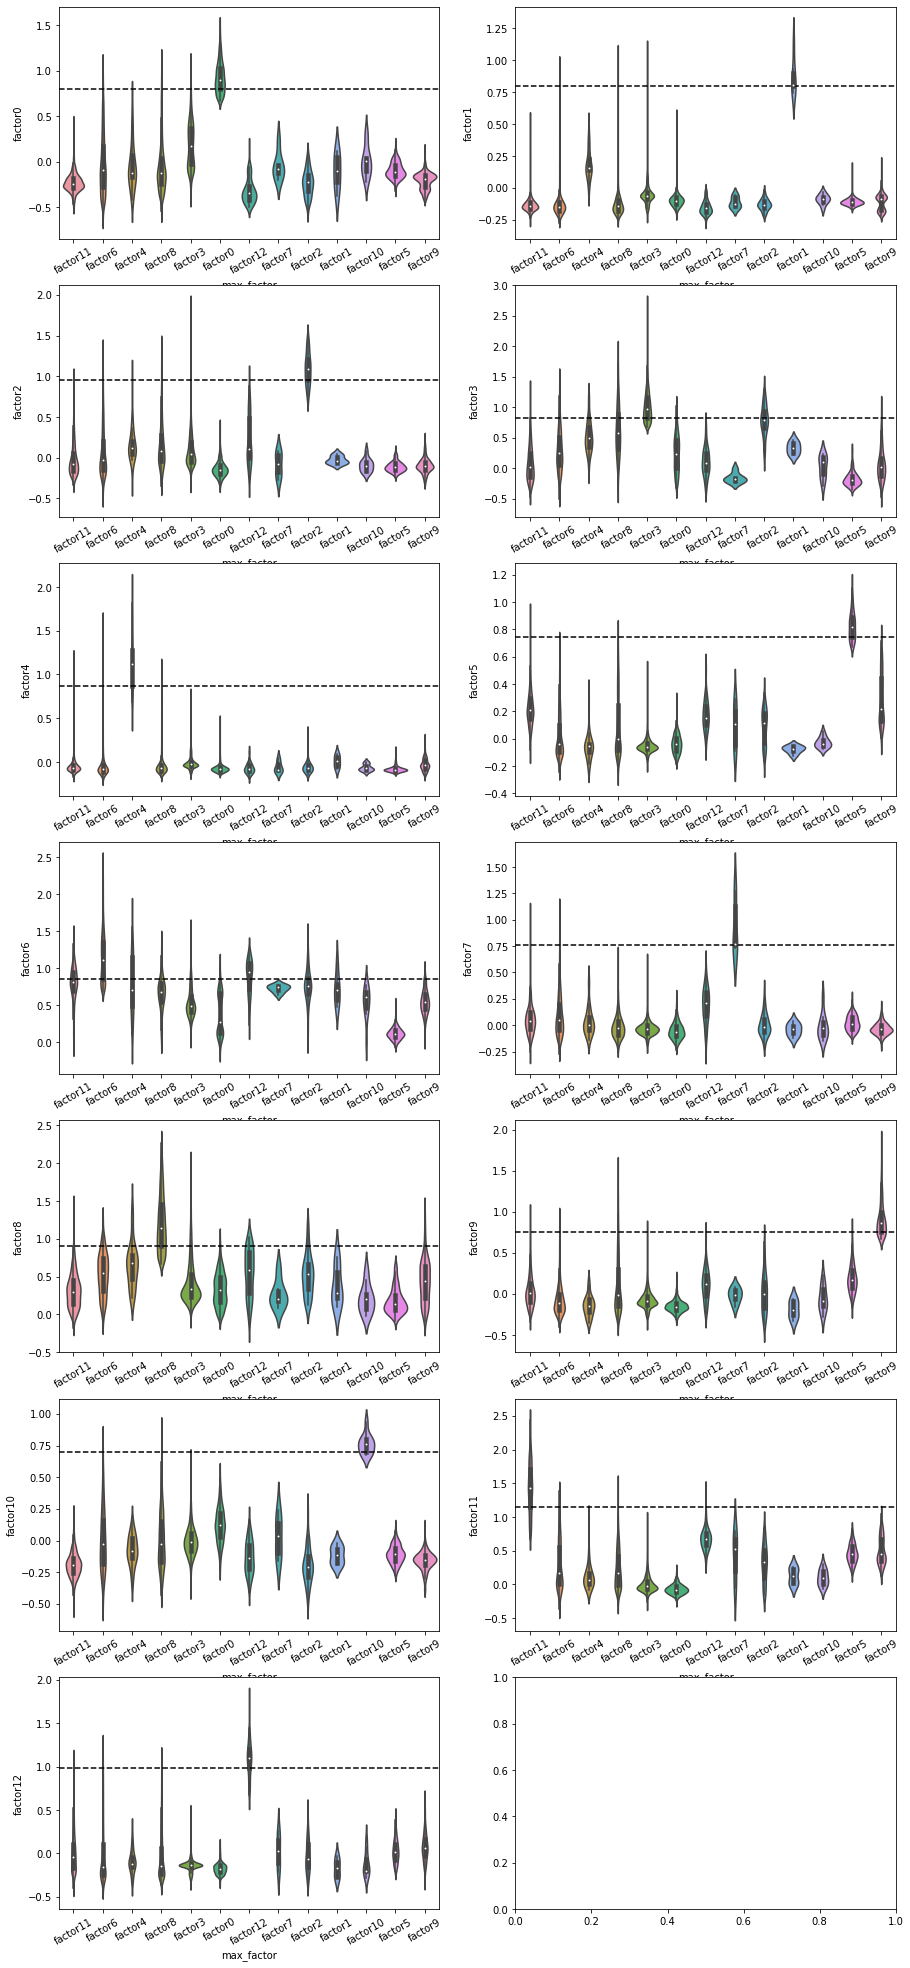

In [16]:
scores, genes_dict = score_modules('Fibroblast_muscle',nmf_components_by_ctype['Fibroblast_muscle'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Fibroblast_muscle',nmf_components_by_ctype['Fibroblast_muscle'])

In [17]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 695 top-scoring cells present in 45 out of 97 samples and 6 datasets

        expected  observed  diff
PCa          299       446   147
normal       234       242     8
CRPC         160         7  -153
chi2 test p-value: 3.148768583734359e-48
 
Top 5 contributing genes:
PLN
SORBS2
NET1
RERGL
BCAM
 
************************
 
factor1: 6 top-scoring cells present in 6 out of 97 samples and 4 datasets

        expected  observed  diff
PCa            2         4     2
normal         2         1    -1
CRPC           1         1     0
chi2 test p-value: 0.4967782012387285
 
Top 5 contributing genes:
CXCR4
CD52
CCL5
CD69
CD3D
 
************************
 
factor2: 61 top-scoring cells present in 13 out of 97 samples and 4 datasets

        expected  observed  diff
PCa           26        25    -1
normal        20        27     7
CRPC          14         9    -5
chi2 test p-value: 0.14162538792260645
 
Top 5 contributing genes:
SOD2
CTSC
SSTR2
CCL2
NCOA7
 
************************
 
fa

In [ ]:
# Rename the columns accordingly
replacements = {'factor0':'myofibrolasts','factor1':'drop',
                    'factor2':'drop','factor3':'stressed infammatory fibroblasts',
                    'factor4':'drop','factor5':'cancer-associated fibroblasts',
                    'factor6':'ribosome CRPC fibroblasts','factor7':'drop',
                    'factor8':'stress response fibroblasts','factor9':'endothelial-like fibroblasts',
                    'factor10':'drop','factor11':'normal fibroblasts',
                    'factor12':'drop'
                    }


for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

## Endothelial

In [ ]:
scores, genes_dict = score_modules('Endothelial',nmf_components_by_ctype['Endothelial'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Endothelial',nmf_components_by_ctype['Endothelial'])

In [ ]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

In [ ]:
# Rename the columns accordingly
replacements = {'factor0':'','factor1':'',
                    'factor2':'','factor3':'',
                    'factor4':'','factor5':'',
                    'factor6':'','factor7':'',
                    'factor8':'','factor9':'',
                    'factor10':'','factor11':'',
                    'factor12':'','factor13':'',
                    'factor14':'','factor15':'',
                    }


for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

## Merging annotations with data

In [ ]:
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [ ]:
adata = sc.read_h5ad('single-cell-reference-subeset-with-broad-annotation.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [ ]:
merged_df = pd.merge(adata.obs, final_annotations, left_index=True, right_index=True, how='left')
merged_df['final_annotation'] = merged_df['final_annotation'].fillna(merged_df['refined_celltypes'])

if (merged_df.index == adata.obs.index).all():
    adata.obs = merged_df.copy()
    print('Done')



In [ ]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]

# Removing factors that were top scorers in less than 100 cells
adata = adata[~(adata.obs['final_annotation']=='drop')]

# Removing cells that scored under the 1st quantile (have their original broad annotation)
adata = adata[~(adata.obs['final_annotation']=='T cell')] # It's named T_cell in the dictionary

for k in list(nmf_components_by_ctype.keys()):
    adata = adata[~(adata.obs['final_annotation']==k)]

In [ ]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

In [ ]:
adata.write('./single-cell-reference-with-nmf-derived-annotations-20230608.h5ad')